![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 06 - Convolutional Neural Network</center>
### <center> 1D convolution and Introduction to Pytorch</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/06_CNN/Main1D_CnnAndPytorch1.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/06_CNN/Cnn1D_ExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- Record figures during training:
from Cnn1D_ExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel

### Generate some data (for frequency estimation):
$$\boldsymbol{x}_{i}\left(t\right)=\sin\left(2\pi f_{i}t+\phi_{i}\right)+n_{i}\left(t\right)$$
**Input**: The signal $x_i(t)$  
**Output**.: The signal frequency $f_i$  


We will use `torch.tensor`, which is very similar to `numpy.ndarray`

In [6]:
Ntrain   = 10000 #-- number of training points
Fs       = 100   #-- sample frequency
T        = 5     #-- observation time (sec)
noiseStd = 0.1

t    = torch.linspace(0, T, T * Fs)   #-- time axis
vF   = torch.rand(Ntrain) * Fs / 30   #-- frequencies
vPhi = 2 * np.pi * torch.rand(Ntrain) #-- random phase

#-- Generate signals: x_i(t) = sin(2π f_i t + φ_i) + n_i(t)
mX = torch.sin(2 * np.pi * vF[:,None] @ t[None,:] + vPhi[:,None])
mX = mX + noiseStd * torch.randn(mX.shape)                        #-- add noise

mX.shape, mX.size() #-- in PyTorch, we have both shape and size().

(torch.Size([10000, 500]), torch.Size([10000, 500]))

### Plot some examples:

Use `torch.Tensor.item()` to get a Python number from a tensor containing a single value:

In [7]:
#-- If we have a tensor 
idx1 = torch.tensor([7])
idx2 = torch.tensor([7]).item()
idx1, idx2

(tensor([7]), 7)

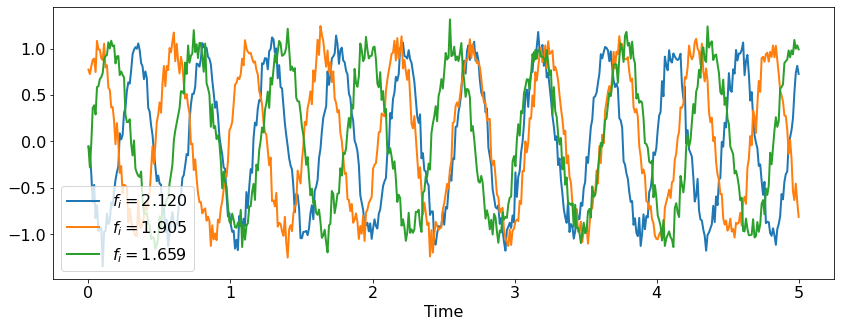

In [8]:
plt.figure(figsize=(14,5))
plt.xlabel('Time')
for _ in range(3):
    idx = torch.randint(0, Ntrain, (1,)).item()
    vX  = mX[idx,:]
    plt.plot(t, vX, lw=2, label=f'$f_i = {(vF[idx].item()):.3f}$')

plt.legend()
plt.show()

### Input data: (N x Channels X Length)
The input to 1D CNN is `NxCxL` so we use `view` to add a new axis (`unsqueeze` will work as well)


In [9]:
mX = mX.view(Ntrain, 1, -1)
mX.shape #-- N x Channels x Length

torch.Size([10000, 1, 500])

### Split data to train and validation:

In [10]:
oDataSet            = torch.utils.data.TensorDataset(mX, vF)
N                   = len(oDataSet)
oTrainSet, oValSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * N, 0.1 * N]).astype(int))
len(oTrainSet), len(oValSet)

(9000, 1000)

### Create data loaders:

In [11]:
batchSize = 512
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize)
oValDL    = torch.utils.data.DataLoader(oValSet,   shuffle=False, batch_size=2*batchSize)

### Define the model (1D CNN):

In [12]:
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torchsummary

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Tensor to vector (reshape):
class Flatten(nn.Module):
    def forward(self, input):
        out = input.view(input.size(0),-1)
        return out

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Just for the summary (identity):
class InputLayer(nn.Sequential):
    pass
    
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#-- Model:
def GetModel():
    oModel = nn.Sequential(
        InputLayer(), #-- does nothing
        
        nn.Conv1d(in_channels=1,   out_channels=50,  kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=50,  out_channels=100, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
        nn.Conv1d(in_channels=200, out_channels=300, kernel_size=11), nn.MaxPool1d(kernel_size=2), nn.ReLU(),
                
        nn.AdaptiveAvgPool1d(output_size=1),
        Flatten(),
        nn.Linear(in_features=300, out_features=1),
    )
    
    return oModel

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchsummary.summary(GetModel(), mX[0,:,:].shape, device='cpu')
print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─InputLayer: 1-1                        [-1, 1, 500]              --
├─Conv1d: 1-2                            [-1, 50, 490]             600
├─MaxPool1d: 1-3                         [-1, 50, 245]             --
├─ReLU: 1-4                              [-1, 50, 245]             --
├─Conv1d: 1-5                            [-1, 100, 235]            55,100
├─MaxPool1d: 1-6                         [-1, 100, 117]            --
├─ReLU: 1-7                              [-1, 100, 117]            --
├─Conv1d: 1-8                            [-1, 200, 107]            220,200
├─MaxPool1d: 1-9                         [-1, 200, 53]             --
├─ReLU: 1-10                             [-1, 200, 53]             --
├─Conv1d: 1-11                           [-1, 300, 43]             660,300
├─MaxPool1d: 1-12                        [-1, 300

### Check whether GPU is available:

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

<IPython.core.display.Javascript object>


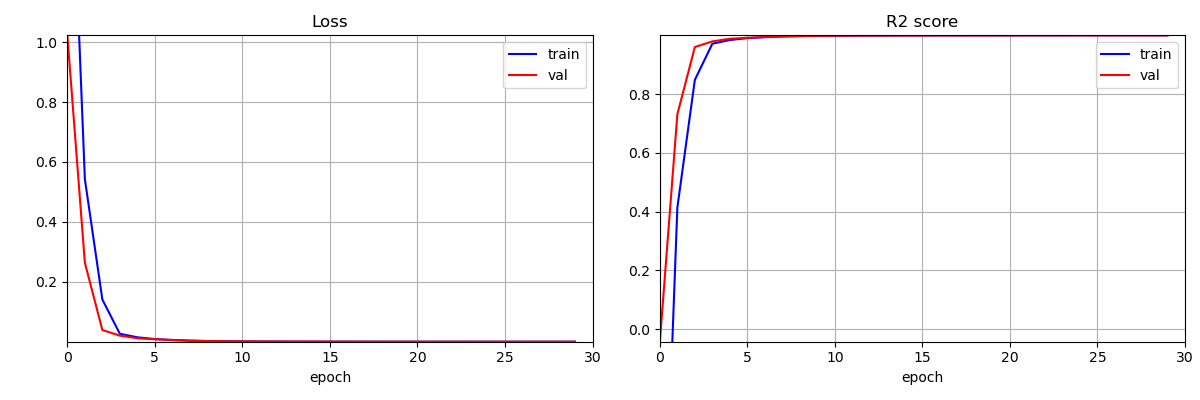

Epoch   0: | Train loss: 2.00668 | Val loss: 1.02240 | Train R2 score: -1.1745 | Val R2 score: -0.0427 | epoch time: 2.997 |
Epoch   1: | Train loss: 0.54310 | Val loss: 0.26391 | Train R2 score: 0.4136 | Val R2 score: 0.7309 | epoch time: 1.902 | <-- Checkpoint!
Epoch   2: | Train loss: 0.14111 | Val loss: 0.03941 | Train R2 score: 0.8482 | Val R2 score: 0.9598 | epoch time: 1.884 | <-- Checkpoint!
Epoch   3: | Train loss: 0.02670 | Val loss: 0.02060 | Train R2 score: 0.9711 | Val R2 score: 0.9790 | epoch time: 1.889 | <-- Checkpoint!
Epoch   4: | Train loss: 0.01511 | Val loss: 0.01183 | Train R2 score: 0.9837 | Val R2 score: 0.9879 | epoch time: 1.965 | <-- Checkpoint!
Epoch   5: | Train loss: 0.00908 | Val loss: 0.00863 | Train R2 score: 0.9902 | Val R2 score: 0.9912 | epoch time: 1.881 | <-- Checkpoint!
Epoch   6: | Train loss: 0.00626 | Val loss: 0.00578 | Train R2 score: 0.9932 | Val R2 score: 0.9941 | epoch time: 1.906 | <-- Checkpoint!
Epoch   7: | Train loss: 0.00406 | Val lo

In [14]:
%matplotlib notebook

oModel   = GetModel().to(device)
oOptim   = optim.Adam(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99))
LossFunc = nn.MSELoss()
TrainModel(oModel, oTrainDL, oValDL, LossFunc, 30, oOptim)

### Test the model:

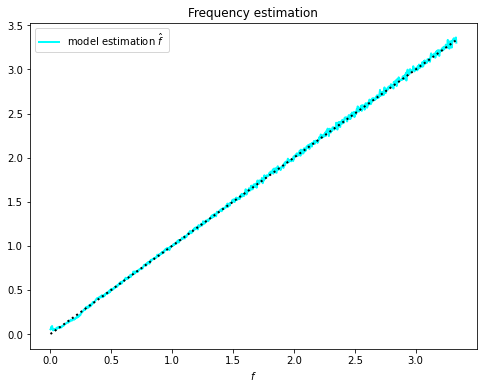

In [16]:
%matplotlib inline

Ntest     = 1001

#-- Generate test data:
vTestF = torch.linspace(0, Fs / 30, Ntest)
mTestX = torch.sin(2 * np.pi * vTestF[:,None] @ t[None,:])
mTestX = mTestX + noiseStd * torch.randn(mTestX.shape)

#-- Apply model:
vHatTestF = oModel(mTestX.view(Ntest,1,-1).to(device)).squeeze()
vHatTestF = vHatTestF.detach().cpu() #-- move to CPU

plt.figure(figsize=(8, 6))
plt.plot(vTestF, vHatTestF, 'cyan', lw=2, label='model estimation $\hat{f}$')
plt.plot(vTestF, vTestF,   ':k',    lw=2)
plt.xlabel('$f$')
plt.title('Frequency estimation')
plt.legend()
plt.show()


### Question:
What will happen if we change (line 6):  
`vTestF = torch.linspace(0, Fs / 30, Ntest)`  
into  
`vTestF = torch.linspace(0, Fs / 20, Ntest)`  
?